In [30]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas as pd
import pandas, xgboost, numpy, textblob, string
from sklearn.metrics import precision_recall_fscore_support

In [11]:
import pandas as pd
df_temp = pd.read_csv('../Data/all_combined.csv')
print(len(df_temp))

237046


In [12]:
df_temp.head()

,Unnamed: 0,state,id,link,county,newspaper,date,content,notice_id,category,...,Fictitious Business Names (DBA),Water Resumes,Tax Deeds,Seizures,Forfeited Property,Estate Claims,count_catogory,category_no_duplicate,category_no_duplicate_str,count_catogory_no_duplicate
0,0,Mississippi,626/2272017_23983816,http://www.publicnoticeads.com/MS/search/view....,Pearl River,Picayune Item,2017/02/24,"notice of auction on friday, march 17, 2017 a...",23983816.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1
1,1,Mississippi,626/2272017_23983815,http://www.publicnoticeads.com/MS/search/view....,Pearl River,Picayune Item,2017/02/24,"public notice on october 28, 2015, the pa sta...",23983815.0,['License Suspension'],...,False,False,False,False,False,False,1,['License Suspension'],['License Suspension'],1
2,6,Louisiana,346/2242017_23980782,http://www.publicnoticeads.com/LA/search/view....,Lincoln,The Ruston Daily Leader,2017/02/24,february 24 legals notice of special elec...,23980782.0,['Elections'],...,False,False,False,False,False,False,1,['Elections'],['Elections'],1
3,17,Louisiana,363/3012017_23987556,http://www.publicnoticeads.com/LA/search/view....,St. Bernard,The St. Bernard Voice,2017/02/24,sheriff's sales bank of america na vs. katedra...,23987556.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1
4,20,Louisiana,363/3012017_23987557,http://www.publicnoticeads.com/LA/search/view....,St. Bernard,The St. Bernard Voice,2017/02/24,sheriff's sales gulf coast bank and trust co v...,23987557.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1


In [13]:
df_temp = df_temp[['content', 'category_no_duplicate']]
df_temp = df_temp.rename(columns={'category_no_duplicate': 'category'})

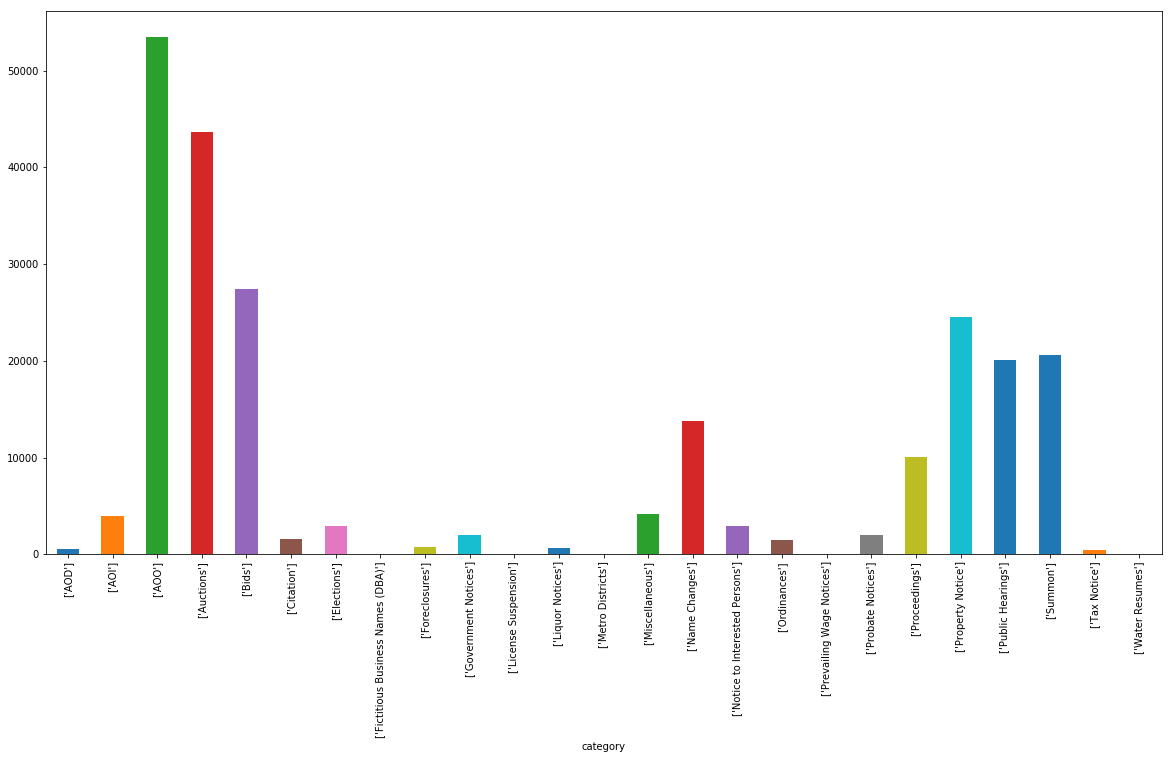

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_temp.groupby('category')['content'].count().plot.bar(ylim=0, figsize=(20,10))
plt.show()

In [16]:
df_temp.category = df_temp.category.str.replace('[','')
df_temp.category = df_temp.category.str.replace(']','')
df_temp.category = df_temp.category.str.replace('\'','')

In [79]:
TARGET  = 'Public Hearings'
df = df_temp[df_temp['category']==TARGET]
n = len(df)
df = df.append(df_temp[df_temp['category']!=TARGET].sample(n=n))

In [80]:
len(df)

40246

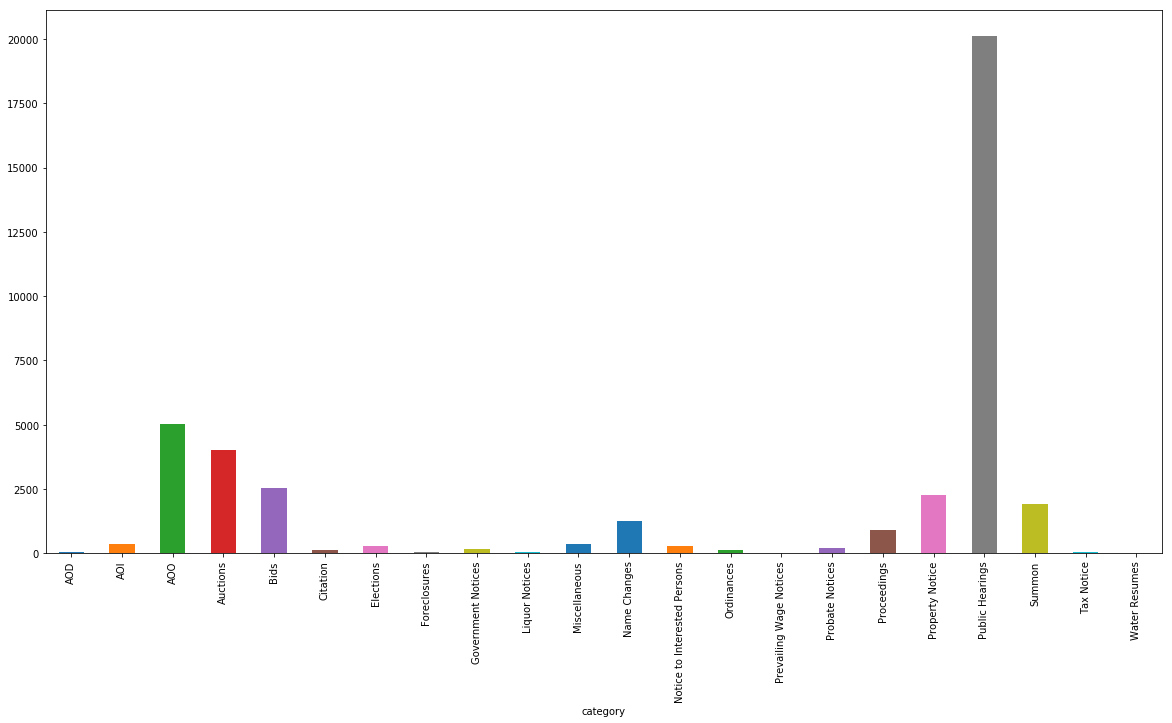

In [81]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category')['content'].count().plot.bar(ylim=0, figsize=(20,10))
plt.show()

In [82]:
def replace_other(row):
    if row !=TARGET:
        return 'Other'
    else:
        return TARGET

In [83]:
df['category_new'] = df.category.apply(replace_other)

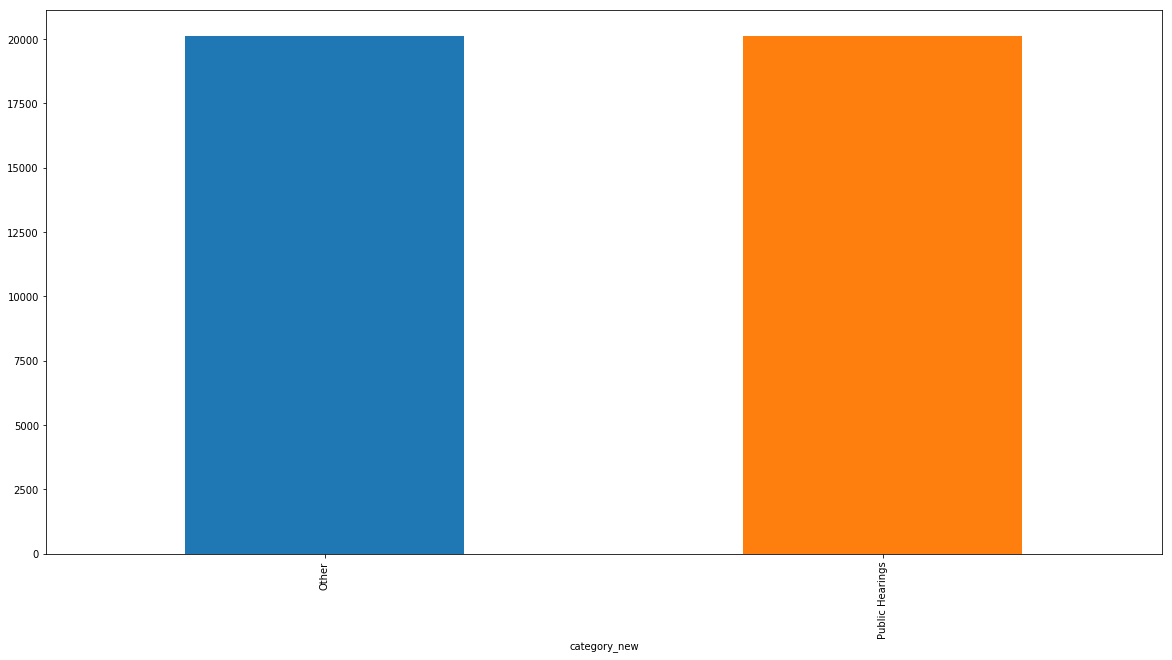

In [84]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category_new')['content'].count().plot.bar(ylim=0, figsize=(20,10))
plt.show()

In [55]:
# # load the dataset
# trainDF = pd.read_csv('../Data/all_combined.csv')
# print(len(trainDF))
# trainDF = trainDF[['content', 'category_no_duplicate']]
# trainDF.head()

# TARGET  = 'Property Notice'
# df = df_temp[df_temp['category']==TARGET]
# df = df.append(df_temp[df_temp['category']!=TARGET].sample(n=n))

# trainDF['content'] = trainDF['content'].astype(str)
# trainDF['category_no_duplicate'] = trainDF['category_no_duplicate'].astype(str)

# trainDF = trainDF.rename(columns={'category_no_duplicate': 'label'})
# trainDF = trainDF.rename(columns={'content': 'text'})

# trainDF.head()

In [85]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['content'], df['category_new'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [86]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['content'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [87]:
print(xtrain_count.shape)
print(xvalid_count.shape)

(30184, 127880)
(10062, 127880)


In [88]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['content'])

xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [89]:
print(xtrain_tfidf.shape)
print(xvalid_tfidf.shape)

(30184, 5000)
(10062, 5000)


In [76]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    conf_mat = confusion_matrix(valid_y, predictions)

    plt.figure(figsize=(9,9))
    sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    scores = precision_recall_fscore_support(valid_y, predictions)#, average='macro')
    print(scores)

#     all_sample_title = 'Accuracy Score: {0}'.format(score)
#     plt.title(all_sample_title, size = 15)

    return metrics.accuracy_score(predictions, valid_y)

(array([0.9720478 , 0.95414634]), array([0.95331744, 0.9725537 ]), array([0.96259152, 0.96326209]), array([5034, 5028], dtype=int64))
NB, Count Vectors:  0.9629298350228582
(array([0.97288414, 0.94262611]), array([0.94080254, 0.97374702]), array([0.95657443, 0.95793387]), array([5034, 5028], dtype=int64))
NB, WordLevel TF-IDF:  0.9572649572649573


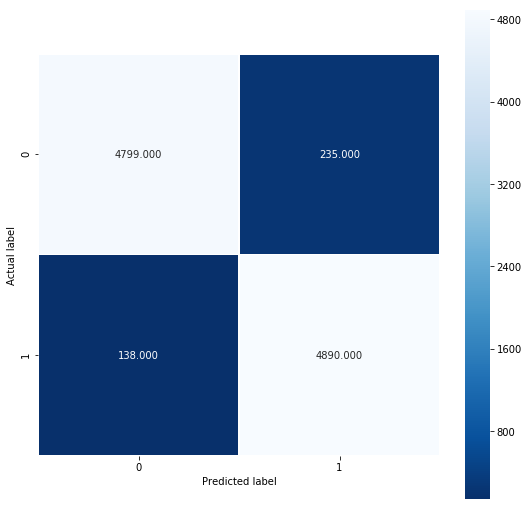

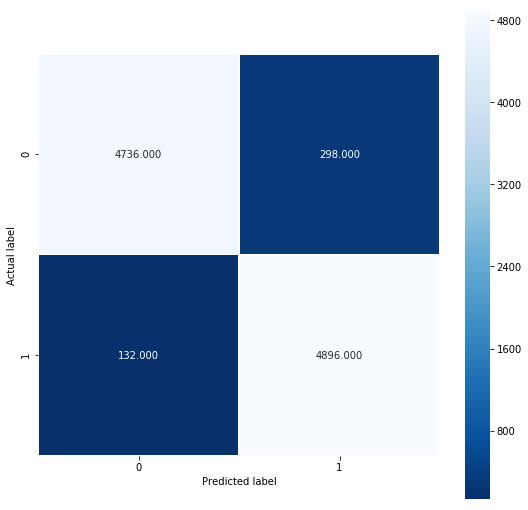

In [90]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "NB, WordLevel TF-IDF: ", accuracy)

(array([0.99262507, 0.98929633]), array([0.98927294, 0.99264121]), array([0.99094617, 0.99096595]), array([5034, 5028], dtype=int64))
LR, Count Vectors:  0.9909560723514211
(array([0.98553636, 0.97482297]), array([0.9745729 , 0.98568019]), array([0.98002397, 0.98022152]), array([5034, 5028], dtype=int64))
LR, WordLevel TF-IDF:  0.9801232359371894


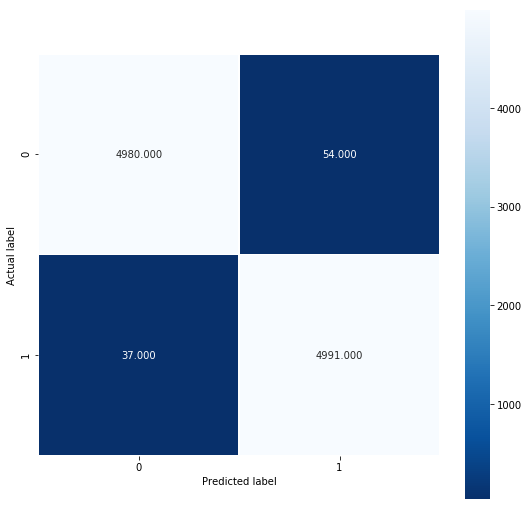

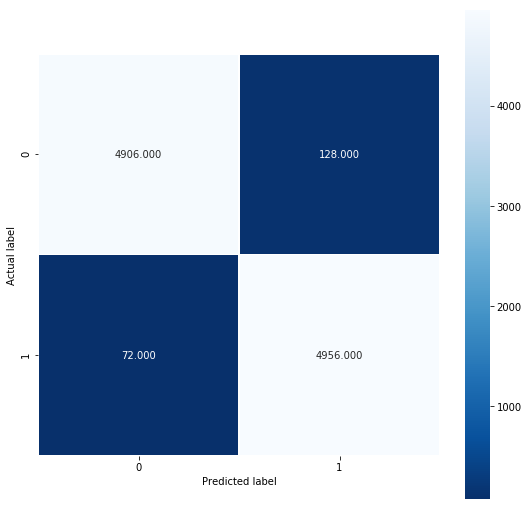

In [91]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print( "LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "LR, WordLevel TF-IDF: ", accuracy)

(0.9027960960168822, 0.8798891786179921, 0.877911703747319, None)
SVM, N-Gram Vectors:  0.8796145050637046


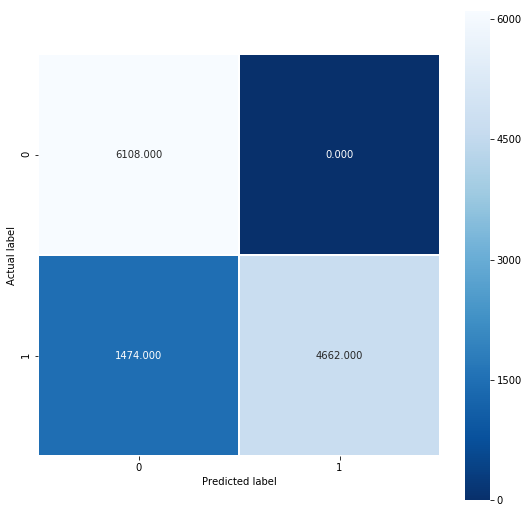

In [38]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVM, N-Gram Vectors: ", accuracy)

(0.9977967965119514, 0.9977987489850231, 0.9977948375673822, None)
RF, Count Vectors:  0.9977948382881411
(0.9979588634931011, 0.9979613480599961, 0.9979581819521361, None)
RF, WordLevel TF-IDF:  0.9979581836001307


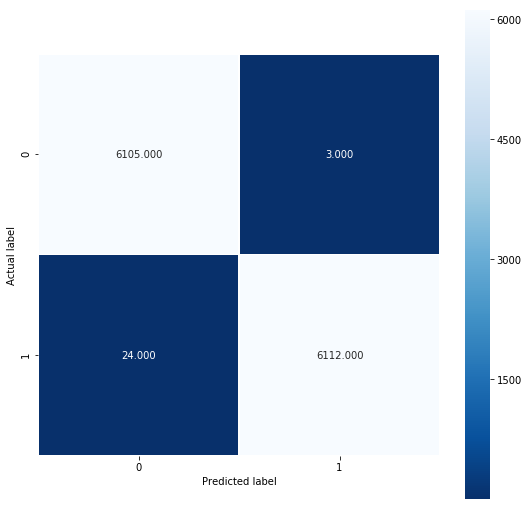

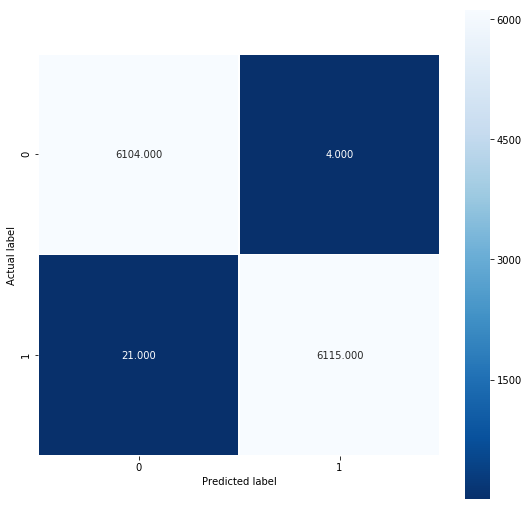

In [39]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0.9983617 , 0.99428255]), array([0.99437948, 0.99833333]), array([0.99636661, 0.99630383]), array([11031, 10800], dtype=int64))
Xgb, Count Vectors:  0.9963354862351702


C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0.99908717, 0.99209268]), array([0.99220379, 0.99907407]), array([0.99563359, 0.99557114]), array([11031, 10800], dtype=int64))
Xgb, WordLevel TF-IDF:  0.9956025834822042


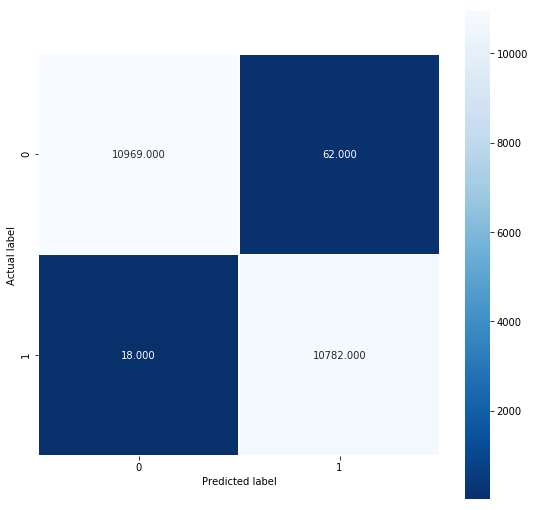

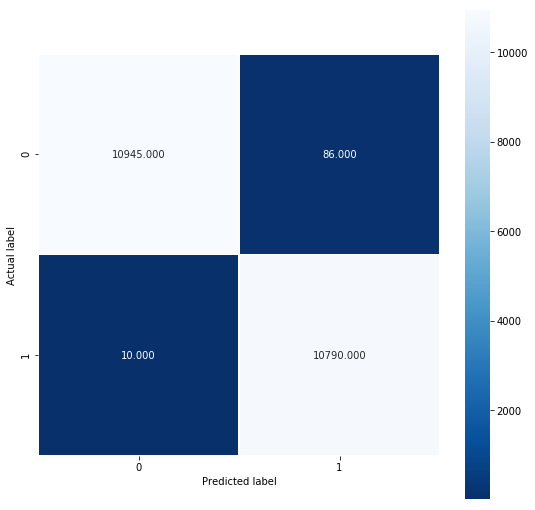

In [78]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print( "Xgb, WordLevel TF-IDF: ", accuracy)